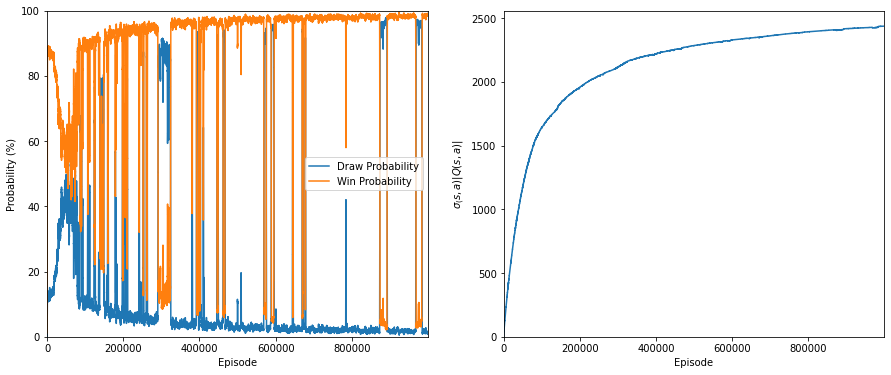

Episode: 999001, Epsilon: 0.010, Win Probability: 99.000, Draw Probability: 1.000


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
from IPython.display import clear_output

# Initialize q-table of shape (states, actions), which is (3 ** 9, 9)
q_table = np.zeros((3 ** 9, 9))

# Learning parameters
episodes = 1000000
learning_rate = 0.01
num_random_episodes = 10000
min_epsilon, max_epsilon = 0.01, 1.0

# Epsilon decay function
def get_epsilon(episode):
  epsilon = max(min_epsilon, min(max_epsilon, num_random_episodes / (episode + 1)))
  return epsilon

# Show graph of exploration strategy
X = np.arange(0, episodes)
Y = np.vectorize(get_epsilon)(X)
fig = plt.figure(figsize = (6, 6))
plt.plot(X, Y)
plt.xlim(0, episodes - 1)
plt.ylim(0, 1)
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.title("Exploration Strategy")
plt.close(fig)
fig.savefig("exploration_strategy.jpg")

# Get available moves
def get_available_moves(board):
  available_moves = np.argwhere(board == 0).tolist()
  return available_moves

# Convert board configuration to an integer state
def board_to_state(board):
  n_states = 3 ** 9
  state = 0

  for x in board.flatten():
    state += ((x + 1) / 3) * n_states
    n_states /= 3

  return int(state)

# Determine if board state is terminal
def is_terminal(board):
  """
  If board is terminal, returns 1 or -1 depending on winner, or 0 if tie
  If board is not terminal, returns None
  """
  """
  
  # Check if any columns are all the same
  column_sum = np.sum(board, axis = 0)
  if np.any(np.abs(column_sum) == 3):
    return int(np.sign(column_sum[np.argmax(np.abs(column_sum))]))

  # Check if any rows are all the same
  row_sum = np.sum(board, axis = 1)
  if np.any(np.abs(row_sum) == 3):
    return int(np.sign(row_sum[np.argmax(np.abs(row_sum))]))

  # Check if either diagonal is all the same
  diagonal_sum = np.array([np.diag(board).sum(), np.diag(np.fliplr(board)).sum()])
  if np.any(np.abs(diagonal_sum) == 3):
    return int(np.sign(diagonal_sum[np.argmax(np.abs(diagonal_sum))]))

  # If no win condition is satisfied, but the board if full, its a tie
  if not np.any(board == 0):
    return 0

  # If the board is not terminal, return None
  return None
  """

  for turn in [-1, 1]:
    mask = board == turn
    out = mask.all(0).any() | mask.all(1).any()
    out |= np.diag(mask).all() | np.diag(mask[:,::-1]).all()
    
    if out:
      return turn

  if not np.any(board == 0):
    return 0

  return None

past_results = []
win_probs = []
draw_probs = []
sum_q_table = []

for episode in range(episodes):
  epsilon = get_epsilon(episode)
  terminal = None
  board = np.zeros((3, 3))
  current_state = board_to_state(board)
  turn = 1
  episode_memory = []

  while not isinstance(terminal, int):
    available_moves = get_available_moves(board)
    if np.random.random() < epsilon:
      action_square = tuple(random.choice(available_moves))
      action = 3 * action_square[0] + action_square[1]
    else:
      actions = q_table[current_state] * turn
      for action in np.argsort(actions)[::-1]:
        action_square = [action // 3, action % 3]
        if action_square in available_moves:
          action_square = tuple(action_square)
          break

    board[action_square] = turn
    new_state = board_to_state(board)
    episode_memory.append([current_state, action, new_state])
    turn *= -1
    terminal = is_terminal(board)

    current_state = new_state

  reward = terminal
  past_results.append(reward)

  # Update q-table
  for current_state, action, new_state in episode_memory:
    q_table[current_state, action] = q_table[current_state, action] + learning_rate * (reward + max(q_table[new_state]) - q_table[current_state, action])

  try:
    averaging_distance = 1000
    draw_freq, win_freq = np.unique(np.abs(past_results[-averaging_distance:]), return_counts = True)[1]
    draw_prob = draw_freq / averaging_distance * 100
    win_prob = win_freq / averaging_distance * 100

    draw_probs.append(draw_prob)
    win_probs.append(win_prob)
  except:
    # If there hasn't been at least one tie and one win, the above code block will raise an exception.
    draw_probs.append(None)
    win_probs.append(None)
    
  sum_q_table.append(np.abs(q_table).sum())

  if episode % 1000 == 0:
    try:
      clear_output(wait = True)
      fig = plt.figure(figsize = (15, 6))
      plt.subplot(1, 2, 1)
      plt.plot(draw_probs, label = "Draw Probability")
      plt.plot(win_probs, label = "Win Probability")
      plt.xlim(0, len(draw_probs) - 1)
      plt.ylim(0, 100)
      plt.xlabel("Episode")
      plt.ylabel("Probability (%)")
      plt.legend()
      plt.subplot(1, 2, 2)
      plt.plot(sum_q_table)
      plt.xlim(0, len(sum_q_table) - 1)
      plt.ylim(0,)
      plt.xlabel("Episode")
      plt.ylabel("$\sigma_(s, a) |Q(s, a)|$")
      plt.show()
      print ("Episode: {}, Epsilon: {:.3f}, Win Probability: {:.3f}, Draw Probability: {:.3f}".format(episode + 1, epsilon, win_probs[-1], draw_probs[-1]))
    except:
      pass

np.save("q_table.npy", q_table)
np.save("draw_probs.npy", draw_probs)
np.save("win_probs.npy", win_probs)

In [1]:
board = np.zeros((3, 3))
terminal = None
print (board, "\n")

while not isinstance(terminal, int):
  current_state = board_to_state(board)
  available_moves = get_available_moves(board)

  actions = q_table[current_state] * 1
  for action in np.argsort(actions)[::-1]:
    action_square = [action // 3, action % 3]
    if action_square in available_moves:
      break

  board[tuple(action_square)] = 1
  print (board, "\n")
  terminal = is_terminal(board)

  if isinstance(terminal, int):
    break

  action_square = input().split(' ')
  action_square = (int(action_square[0]), int(action_square[1]))
  board[action_square] = -1
  print (board, "\n")
  terminal = is_terminal(board)

  if isinstance(terminal, int):
    break

NameError: ignored